## Domača naloga 8
Marko Tacer, 23222087

Podatki:
$$\mu = 1,75$$
$$A_{pp} = 1,1$$
$$f_{k} = 39$$
$$\Delta f = 0,25 $$

In [1]:
import lvm_read
import matplotlib.pyplot as plt
from scipy import stats, integrate
import numpy as np
%matplotlib inline

### Kvantizacija


Za nalogo pri tej vaji smo obdelali signal naključnih napetosti.  Spodaj je signal obdelan in primerjan s podanimi vrednostmi.

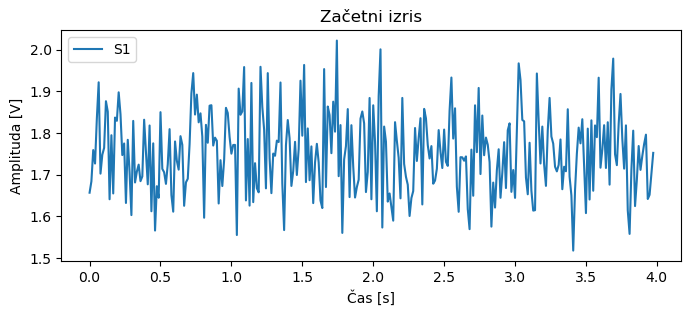

In [2]:
file = f'Signal3.lvm'
loaded_data = lvm_read.read(file)
loaded_data[0]['data'].shape[0]
#preberemo vse podatke, vsak stolpec zase

S = loaded_data[0]['data'].T 
# Za prvi del naloge samo 4s podatkov
N_p = S[0][:311] 
t = S[1][:311]
dt = t[1]-t[0]
s1 = S[2][:311]

s1
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_title("Začetni izris")
ax.plot(t, s1, label='S1')
ax.set_xlabel('Čas [s]')
ax.set_ylabel('Amplituda [V]')
ax.legend();

In [3]:
print(f'Average S1: {np.mean(s1):.3f}')

Average S1: 1.752


## Diskretna Fourierjeva transformacija

Frekvenčno območje: 38.87, v podatkih 39 Hz
Frekvenčna ločljivost: 0.25, v podatkih 0.25 Hz


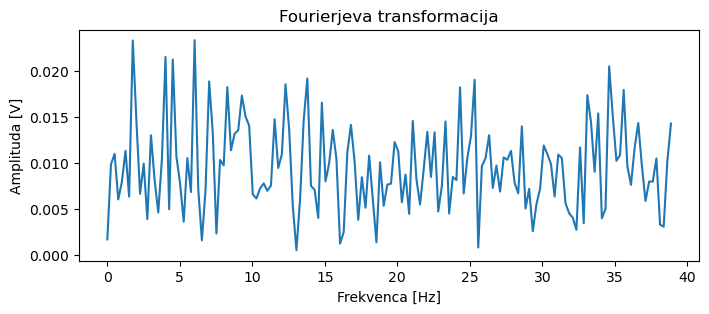

In [4]:
S1_F = abs(np.fft.rfft(s1-1.75)/len(s1))
S1_F[1:]*=2
freq = np.fft.rfftfreq(len(t), d=dt)
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_title("Fourierjeva transformacija")
ax.plot(freq, np.abs(S1_F), label='S1')
ax.set_xlabel('Frekvenca [Hz]')
ax.set_ylabel('Amplituda [V]')
print(f'Frekvenčno območje: {freq[-1]:.2f}, v podatkih 39 Hz')
print(f'Frekvenčna ločljivost: {freq[1]:.2f}, v podatkih 0.25 Hz')

## Ocena gostote porazdelitve

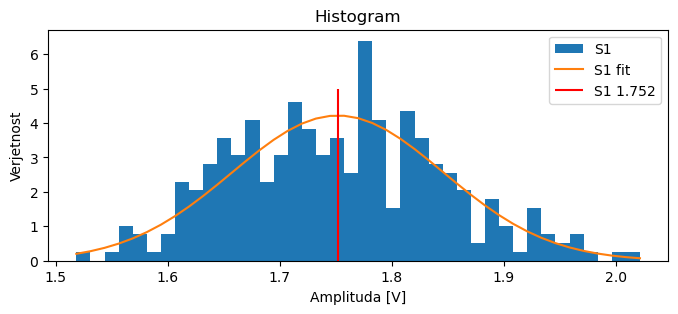

In [6]:
N1 = len(s1)
mu1 = np.mean(s1)
sigma1 = np.std(s1)
b = 40
fig, ax1 = plt.subplots(figsize=(8, 3))
ax1.set_title("Histogram")
hist1, bins1, _ = ax1.hist(s1, bins=b, density=True, label='S1')
ax1.plot(bins1, stats.norm.pdf(bins1, mu1, sigma1), label='S1 fit')
ax1.vlines(mu1, 0, 5, color='r', label=f'S1 {mu1:.3f}')
ax1.set_xlabel('Amplituda [V]')
ax1.set_ylabel('Verjetnost')
ax1.legend()

### Enostranska in dvostranska avtospektralna gostota moči $G_{XX}$ in $S_{XX}$

Določimo avokorelacijsko funkcijo. definiramo enostransko in dvostransko avtospektralno gostoto.

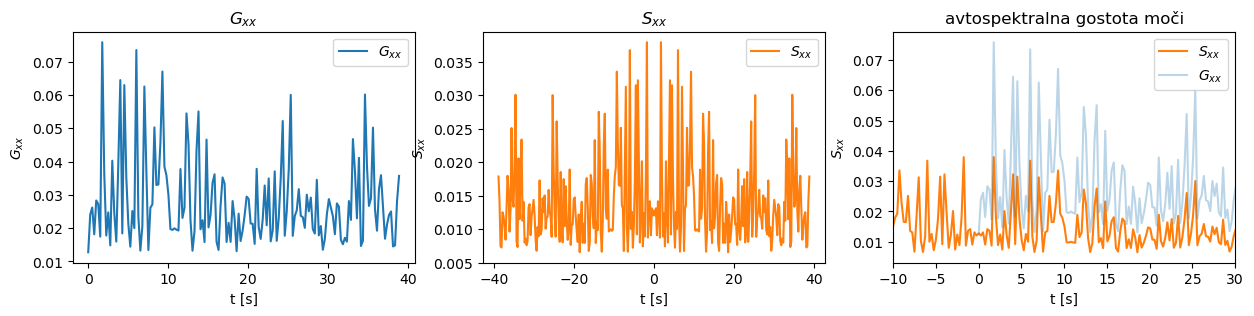

In [7]:
R_xx = np.correlate(s1-mu1, s1-mu1, mode='full') / sigma1**2 / N1   #avtokorelacija = korelacija signala samega s seboj
R_xx = R_xx[-len(s1):]                                              #odrežemo negativne čase (za definicijo enostranskega spektra)

G_xx = np.fft.rfft(R_xx) / len(R_xx) * 2 * t[-1]                    #Fourierjeva transformacija avtokorelacijske funkcije
freq_xx = np.fft.rfftfreq(len(s1), t[1])                            #definicija frekvenc

S_xx = np.hstack([-G_xx[::-1], G_xx[1:]])/2                         #definicija dvostranskega spektra (polovico manjši)
S_xx[len(S_xx)//2] = G_xx[0]                                        #popravek za enosmerni člen (pri frekvenci 0)
freq_sxx = np.hstack([-freq_xx[::-1], freq_xx[1:]])

# prikaz
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))


ax1.plot(freq_xx, abs(G_xx),label='$G_{xx}$')
ax1.set_title(f'$G_{{xx}}$')                         
ax1.set_xlabel('t [s]')        
ax1.set_ylabel('$G_{xx}$')                             
ax1.legend();

ax2.set_title(f'$S_{{xx}}$')   
ax2.plot(freq_sxx, abs(S_xx), c='C1', label='$S_{xx}$')
ax2.set_xlabel('t [s]')
ax2.set_ylabel('$S_{xx}$')
ax2.legend()

ax3.set_title('avtospektralna gostota moči')   
ax3.plot(freq_sxx, abs(S_xx), c='C1', label='$S_{xx}$')
ax3.plot(freq_xx, abs(G_xx), alpha=0.3, label='$G_{xx}$')
ax3.set_xlim(-10, 30)
ax3.set_xlabel('t [s]')
ax3.set_ylabel('$S_{xx}$')
ax3.legend();

### Izračun momentov

In [8]:
statisticni_momenti = np.zeros(4)
s1_c = s1 - mu1
for i in range(4):
    statisticni_momenti[i] = np.mean((s1_c)**(i+1))
    print(f'{i+1}. moment (m{i+1}): {statisticni_momenti[i]:.7f}')
    
print(f'm_2 = {statisticni_momenti[1]:.7f} ==> sigma1^2 =  {sigma1**2:.7f}')

1. moment (m1): -0.0000000
2. moment (m2): 0.0089428
3. moment (m3): 0.0001803
4. moment (m4): 0.0002116
m_2 = 0.0089428 ==> sigma1^2 =  0.0089428


Vidmo, da je prvi moment enak nič, kar je za naš signal za centralni moment pričakovano ("enakomerno" se giba okoli 0). Drugi momenti pa je enak varianci oz std na kvadrat:
$${m_2} = \sigma^{2}$$

### Stacionarnost in Ergodičnost

Zajeli smo 10 zaporednih meritev (vsako po 4s), s pomočjo katerih bomo gledali stacionarnost in ergodičnost procesa

In [9]:
S_sk = np.zeros((10, 311))
S_sk_flatten = S_sk.flatten()
N_sk = np.zeros((10))
mu_sk = np.zeros((10))
sigma_sk = np.zeros((10))
var_sk = np.zeros((10))
momenti_sk = np.zeros((10, 4))
S = loaded_data[0]['data'].T
for i in np.arange(10):
    S_sk[i] = S[2][i*311:(i+1)*311]
    mu_sk[i] = np.mean(S_sk[i])
    sigma_sk[i] = np.std(S_sk[i])
    s_c = S_sk[i] - mu_sk[i]
    var_sk[i] = np.var(S_sk[i])
    for j in range(4):
        momenti_sk[i][j] = np.mean((s_c)**(j+1))

Text(0.5, 0, 'Čas [s]')

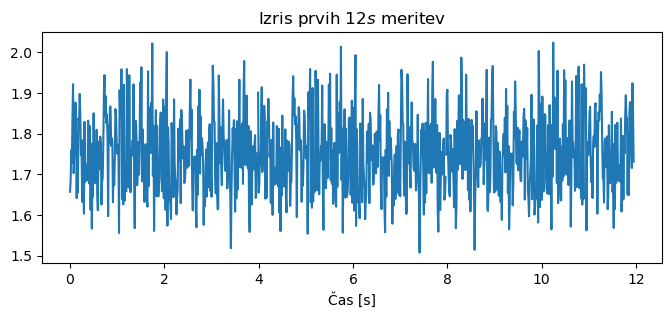

In [10]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_title(f"Izris prvih 12$s$ meritev")
T = t[-1] + t[1]
for i in np.arange(3):
    ax.plot(i*T+t, S_sk[i], c='C0')
ax.set_xlabel('Čas [s]')

Za osnovni popis stacionarnosti moramo primerjati statistične momente (višje). Za začetek prvi in drugi moment.


In [11]:
# Poglejmo še povprečje vsega skupaj
mu_sk_all = np.mean(S_sk)
# Še varianco vsega skupaj
var_sk_all = np.var(S_sk)

Skupna povprečna vrednost: 1.7519315
Skupna varianca: 0.0090831


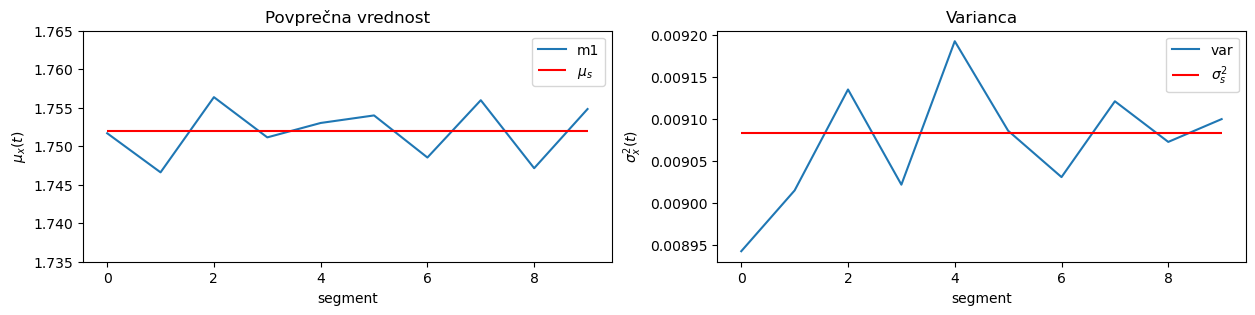

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))

ax1.plot(mu_sk[:], label='m1')
ax1.set_title(f'Povprečna vrednost')                         
ax1.set_xlabel('segment')
ax1.set_ylim(1.735, 1.765)
ax1.set_ylabel('$\mu_x(t)$');
ax1.hlines(mu_sk_all, 0, 9, color='r', label=f'$\mu_s$')
ax1.legend();

ax2.set_title(f'Varianca')
ax2.plot(var_sk[:], label='var')
ax2.set_xlabel('segment')
ax2.set_ylabel('$\sigma^2_x(t)$');
ax2.hlines(var_sk_all, 0, 9, color='r', label=f'$\sigma^2_s$')
ax2.legend();

print(f'Skupna povprečna vrednost: {mu_sk_all:.7f}')
print(f'Skupna varianca: {var_sk_all:.7f}')

Vidimo, da povprečna vrednost večinoma odstopa do +/- 0.01, varianca pa +/- 0.00015. V absolutnem smislu so to majhne številke, relativno pa povprečna vrednost odstopa 0.6%, varianca pa mnogo več - več kot 16%.

### Dodatek 2: Numerično generiran nestacionarni gaussov ter stacionarni ne-gaussov naključni signala

Za Gaussov signal je značilno, da ima kurtosis parameter enak 3. Če želimo, da je nestacionaren ga moduliramo. Za stacionaren Ne-Gaussov signal pa definiramo signal, ki ima kurtosis različen od 3.

In [13]:
import pyExSi as es
N = 2**12 # Število časovnih točk
fs = 1024 # Frekvenca vzorčenja [Hz]
t = np.arange(0, N)/fs # time vector

freq = np.arange(0, N//2 + 1, 1) * fs / N   # Naredimo frekvenčni vektor
PSD = es.get_psd(freq, 50, 100) # Definiramo PSD
# Amplitudna modulacija s pomočjo PSD
PSD_modulating = es.get_psd(freq, freq_lower=1, freq_upper=100)
#define array of parameters delta_m and p
delta_m_list = np.arange(.1,2.1,.5)
p_list = np.arange(.1,2.1,.5)

Zdaj generiramo ta Gaussov signal s $k_u=3$ in ga moduliramo. V nasledni vrsti definiramo samo stacionaren ne-gaussov signal, torej $k_u \ne 3$.

In [14]:
G_nestacionarni_signal = es.nonstationary_signal(N, PSD, fs, k_u = 3, modulating_signal=('PSD', PSD_modulating), param1_list=p_list,param2_list=delta_m_list)
G_stacionarni_negausov_signal = es.stationary_nongaussian_signal(N, PSD, fs, s_k=0, k_u=6)

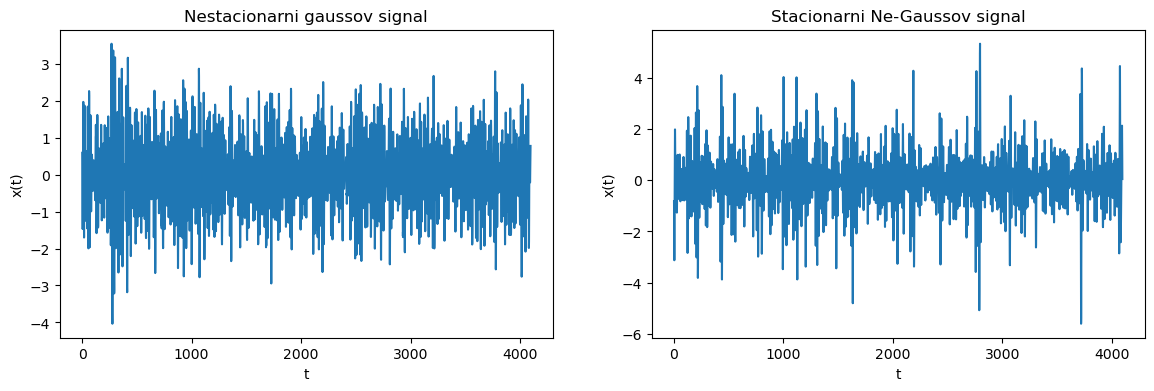

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(G_nestacionarni_signal)
ax1.set_title('Nestacionarni gaussov signal')
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')

ax2.plot(G_stacionarni_negausov_signal)
ax2.set_title('Stacionarni Ne-Gaussov signal')
ax2.set_xlabel('t')
ax2.set_ylabel('x(t)');